# Introducing PDF reader in SparkNLP
This notebook showcases the newly added  `sparknlp.read().pdf()` method in Spark NLP that parses PDF content from both local files and distributed file systems into a Spark DataFrame.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp drive/MyDrive/JSL/sparknlp/sparknlp.jar .
!cp drive/MyDrive/JSL/sparknlp/spark_nlp-6.0.2-py2.py3-none-any.whl .

In [3]:
%env PYSPARK=3.4.0

env: PYSPARK=3.4.0


In [4]:
!pip install PYSPARK

In [5]:
!pip install spark_nlp-6.0.2-py2.py3-none-any.whl

Processing ./spark_nlp-6.0.2-py2.py3-none-any.whl


In [6]:
# import sparknlp
# # let's start Spark with Spark NLP
# spark = sparknlp.start()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkNLP") \
    .master("local[*]") \
    .config("spark.driver.memory", "12G") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.kryoserializer.buffer.max", "2000M") \
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.jars", "./sparknlp.jar") \
    .getOrCreate()


print("Apache Spark version: {}".format(spark.version))

Apache Spark version: 3.5.1


## Setup and Initialization
Let's keep in mind a few things before we start 😊

Support for reading pdf files was introduced in Spark NLP 5.5.2 Please make sure you have upgraded to the latest Spark NLP release.

For local files example we will download a couple of PDF files from Spark NLP Github repo:

In [7]:
!mkdir pdf-examples
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/pdf-title.pdf -P pdf-examples
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/text_3_pages.pdf -P pdf-examples

--2025-06-05 21:14:42--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/pdf-title.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25803 (25K) [application/octet-stream]
Saving to: ‘pdf-examples/pdf-title.pdf’

pdf-title.pdf       100%[===================>]  25.20K  --.-KB/s    in 0.009s  

2025-06-05 21:14:43 (2.82 MB/s) - ‘pdf-examples/pdf-title.pdf’ saved [25803/25803]

--2025-06-05 21:14:43--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/text_3_pages.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.1

In [8]:
!mkdir scattered-pdf-files
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/unsorted_text.pdf -P scattered-pdf-files

--2025-06-05 21:14:44--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-textStripper/src/test/resources/reader/pdf/unsorted_text.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1563 (1.5K) [application/octet-stream]
Saving to: ‘scattered-pdf-files/unsorted_text.pdf’

unsorted_text.pdf   100%[===================>]   1.53K  --.-KB/s    in 0s      

2025-06-05 21:14:44 (23.5 MB/s) - ‘scattered-pdf-files/unsorted_text.pdf’ saved [1563/1563]



In [9]:
!mkdir coordinates-pdf-files
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-extractCoordinates/src/test/resources/reader/pdf/ligatures_text.pdf -P coordinates-pdf-files

--2025-06-05 21:14:44--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/feature/SPARKNLP-1098-Adding-a-PDF-Reader-extractCoordinates/src/test/resources/reader/pdf/ligatures_text.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19436 (19K) [application/octet-stream]
Saving to: ‘coordinates-pdf-files/ligatures_text.pdf’

ligatures_text.pdf  100%[===================>]  18.98K  --.-KB/s    in 0.006s  

2025-06-05 21:14:45 (3.24 MB/s) - ‘coordinates-pdf-files/ligatures_text.pdf’ saved [19436/19436]



In [10]:
!ls -lh coordinates-pdf-files

total 20K
-rw-r--r-- 1 root root 19K Jun  5 21:14 ligatures_text.pdf


Let's install some packages to visualize the PDFs documents

In [11]:
!apt-get install poppler-utils
!pip install pdf2image

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 1s (126 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126111 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


## Parsing PDFs from Local Files
Use the `pdf()` method to parse Excel content from local directories.

- Update introduced in SparkNLP X.Y.Z: pdf reader now also identifies the pages for each PDF file

In [12]:
import sparknlp

pdf_df = sparknlp.read().pdf("./pdf-examples")
pdf_df.show()

+--------------------+--------------------+------+--------------------+---------+----------------+---------------+-------+---------+-------+
|                path|    modificationTime|length|                text|positions|height_dimension|width_dimension|content|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+----------------+---------------+-------+---------+-------+
|file:/content/pdf...|2025-06-05 21:14:...| 25803|This is a Title \...|     NULL|             842|            596|   NULL|     NULL|      0|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|   This is a page.\n|     NULL|             841|            595|   NULL|     NULL|      0|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|This is another p...|     NULL|             841|            595|   NULL|     NULL|      1|
|file:/content/pdf...|2025-06-05 21:14:...|  9487| Yet another page.\n|     NULL|             841|            595|   NULL|     NULL|      2|
+------------

In [13]:
pdf_df.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- text: string (nullable = true)
 |-- positions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- mapping: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- c: string (nullable = true)
 |    |    |    |    |-- x: float (nullable = false)
 |    |    |    |    |-- y: float (nullable = false)
 |    |    |    |    |-- width: float (nullable = false)
 |    |    |    |    |-- height: float (nullable = false)
 |    |    |    |    |-- fontSize: integer (nullable = false)
 |    |    |    |    |-- source: string (nullable = true)
 |-- height_dimension: integer (nullable = true)
 |-- width_dimension: integer (nullable = true)
 |-- content: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- pagenum: integer (nullable = true)



You can also use DFS file systems like:
- Databricks: `dbfs://`
- HDFS: `hdfs://`
- Microsoft Fabric OneLake: `abfss://`

### Configuration Parameters

You can customize the behavior of PDF reader with some parameters.

- `storeSplittedPdf`: By default, it's `false`. When it's `true` it stores bytes content of splitted pdf in `content` column

In [14]:
params = {"storeSplittedPdf": "true"}
pdf_df = sparknlp.read(params).pdf("./pdf-examples")
pdf_df.show()

+--------------------+--------------------+------+--------------------+---------+----------------+---------------+--------------------+---------+-------+
|                path|    modificationTime|length|                text|positions|height_dimension|width_dimension|             content|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+----------------+---------------+--------------------+---------+-------+
|file:/content/pdf...|2025-06-05 21:14:...| 25803|This is a Title \...|     NULL|             842|            596|[25 50 44 46 2D 3...|     NULL|      0|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|   This is a page.\n|     NULL|             841|            595|[25 50 44 46 2D 3...|     NULL|      0|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|This is another p...|     NULL|             841|            595|[25 50 44 46 2D 3...|     NULL|      1|
|file:/content/pdf...|2025-06-05 21:14:...|  9487| Yet another page.\n|     

- `setSplitPage`: Introduced in SparkNLP X.Y.Z. By default, it's `true`. When it's `false` it does not identify pages in the PDF documents

In [15]:
params = {"splitPage": "false"}
pdf_df = sparknlp.read(params).pdf("./pdf-examples")
pdf_df.show()

+--------------------+--------------------+------+--------------------+---------+----------------+---------------+-------+---------+-------+
|                path|    modificationTime|length|                text|positions|height_dimension|width_dimension|content|exception|pagenum|
+--------------------+--------------------+------+--------------------+---------+----------------+---------------+-------+---------+-------+
|file:/content/pdf...|2025-06-05 21:14:...| 25803|This is a Title \...|     NULL|             842|            596|   NULL|     NULL|      0|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|This is a page.\n...|     NULL|             841|            595|   NULL|     NULL|      0|
+--------------------+--------------------+------+--------------------+---------+----------------+---------------+-------+---------+-------+



- `onlyPageNum`: Introduced in SparkNLP X.Y.Z. By default, it's `false`. When it's `true` it only identifies page numbers in the PDF documents.

In [16]:
params = {"onlyPageNum": "true"}
pdf_df = sparknlp.read(params).pdf("./pdf-examples")
pdf_df.show()

+--------------------+--------------------+------+----+---------+----------------+---------------+-------+---------+-------+
|                path|    modificationTime|length|text|positions|height_dimension|width_dimension|content|exception|pagenum|
+--------------------+--------------------+------+----+---------+----------------+---------------+-------+---------+-------+
|file:/content/pdf...|2025-06-05 21:14:...| 25803|    |     NULL|               1|              1|   NULL|     NULL|      1|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|    |     NULL|               1|              1|   NULL|     NULL|      1|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|    |     NULL|               1|              1|   NULL|     NULL|      2|
|file:/content/pdf...|2025-06-05 21:14:...|  9487|    |     NULL|               1|              1|   NULL|     NULL|      3|
+--------------------+--------------------+------+----+---------+----------------+---------------+-------+---------+-------+


- `setTextStripper`: Introduced in SparkNLP X.Y.Z. It can have two vaules:
  - PDFTextStripper: This is the default. It extracts text from a PDF, but the output often loses the original layout and formatting.
  - PDFLayoutTextStripper: This customized version enhances PDF Text Stripper by preserving the visual layout.

- `sort`: Introduced in SparkNLP X.Y.Z. It's default is `false`. We suggest to set it as `true` when using PDFLayoutTextStripper because it sorts and organizes text positions to retain a structure closer to the original document.

To better understand the benefit of using `PDFLayoutTextStripper` and `sort` let's check the PDF below

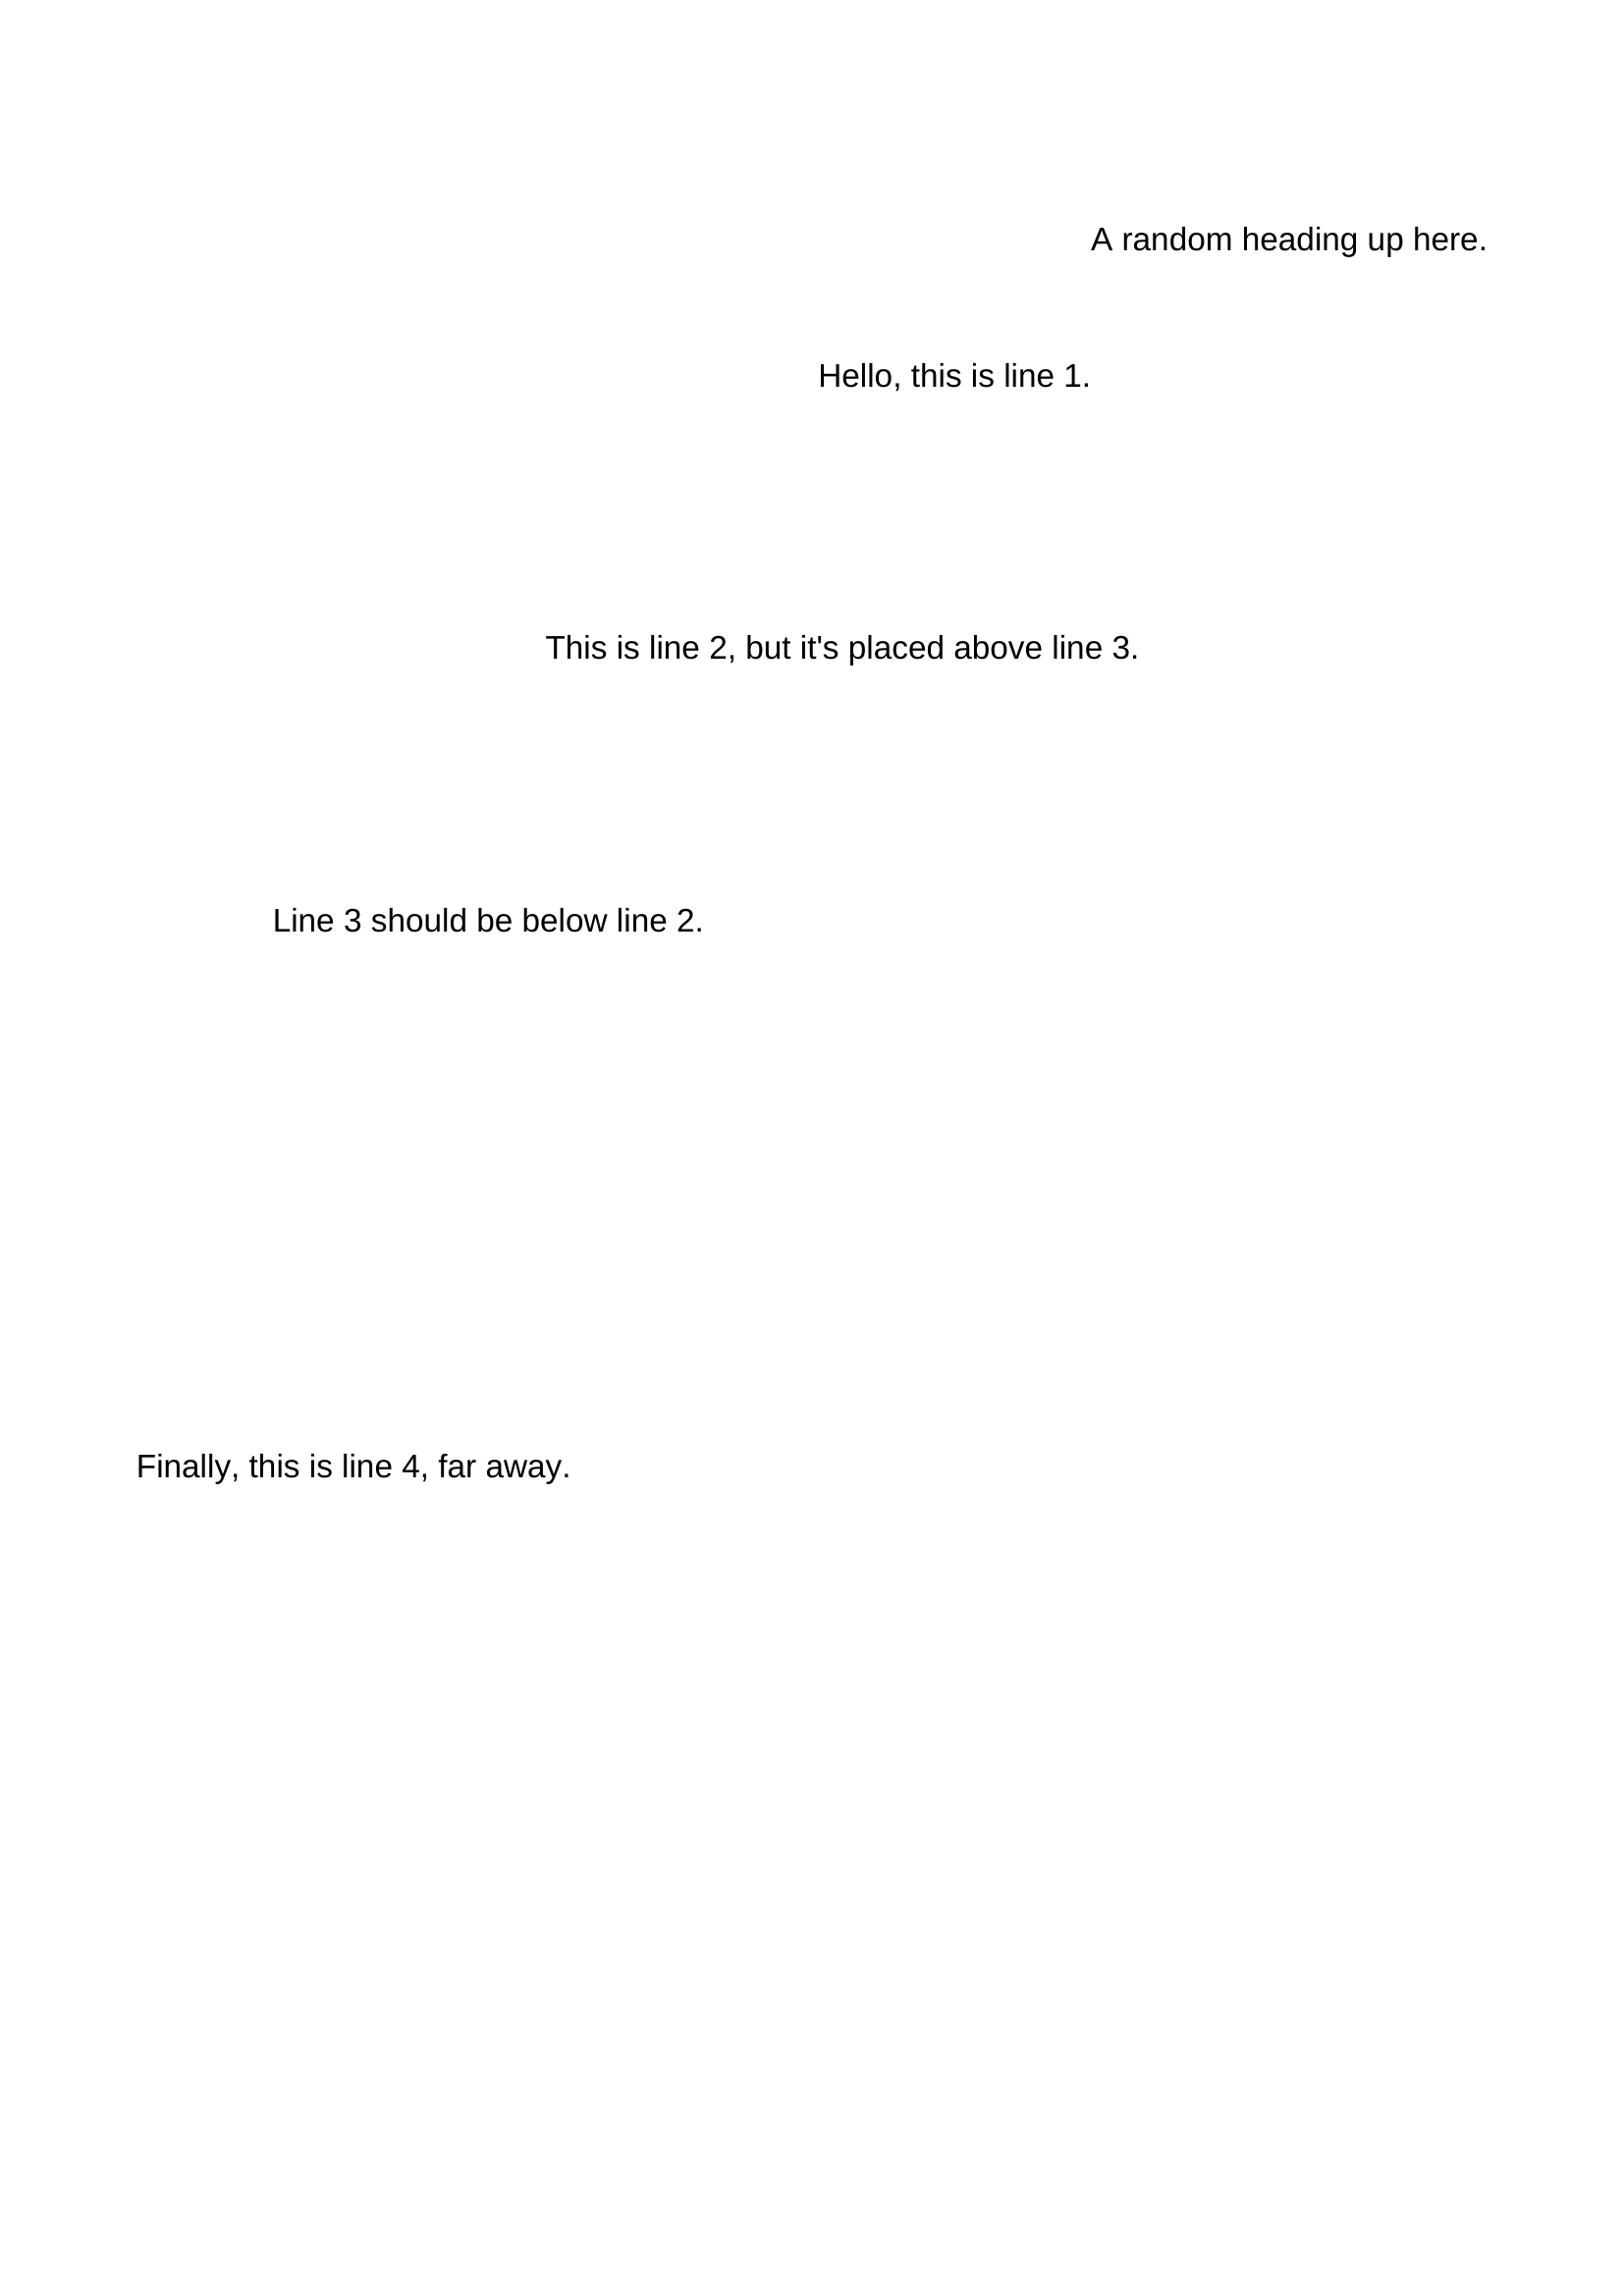

In [17]:
from pdf2image import convert_from_path
from IPython.display import display

pdf_path = "./scattered-pdf-files/unsorted_text.pdf"

images = convert_from_path(pdf_path)
for img in images:
    display(img)

Now, let's see at the result of parsing this scattered PDF:

In [18]:
pdf_df = sparknlp.read().pdf("./scattered-pdf-files")
pdf_df.select("text").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                  |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Hello, this is line 1.\nLine 3 should be below line 2.\nThis is line 2, but it's placed above line 3.\nFinally, this is line 4, far away.\nA random heading up here.\n|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------+



As you can see in the result output and the PDF above content is not necessarily stored in reading order. It may be scattered due to:

- Different text extraction strategies.
- Complex PDF layouts with multiple columns, tables, etc.

Through `PDFLayoutTextStripper` and sorting we can ensure that text is arranged in a human-readable order, following a logical left-to-right and top-to-bottom flow, as shown below:

In [19]:
from pyspark.sql.functions import *

params = {"textStripper": "PDFLayoutTextStripper", "sort": "true"}
pdf_df = sparknlp.read(params).pdf("./scattered-pdf-files")
pdf_df.select(trim(regexp_replace(col("text"), "\\s+", " "))).show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|trim(regexp_replace(text, \s+,  , 1))                                                                                                                           |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|A random heading up here. Hello, this is line 1. This is line 2, but it's placed above line 3. Line 3 should be below line 2. Finally, this is line 4, far away.|
+----------------------------------------------------------------------------------------------------------------------------------------------------------------+



- `extractCoordinates`: Introuced in SparkNLP X.Y.Z, by default is `false`. When it's `true` force extracting coordinates of text in a `positions` column

- `normalizeLigatures`: This parameter was introduced in SparkNLP X.Y.Z. By default, it is set to `true`, meaning that ligatures are automatically mapped to their corresponding individual characters. When set to `false`, ligatures remain unchanged in the text.

**What Are Ligatures?**

Ligatures are special character combinations that merge two or more letters into a single glyph. They are commonly used in typography to enhance readability, aesthetics, and spacing between certain letter pairs.

Currently, the PDF reader maps the following ligatures:

| Ligature | Mapped To  |
|----------|-----------|
| **ﬀ**    | `["f", "f"]` |
| **ﬁ**    | `["f", "i"]` |
| **ﬂ**    | `["f", "l"]` |
| **ﬃ**    | `["f", "f", "i"]` |
| **ﬄ**    | `["f", "f", "l"]` |
| **ﬆ**    | `["s", "t"]` |
| **œ**    | `["o", "e"]` |

By enabling `normalizeLigatures`, SparkNLP ensures consistent text representation by replacing these ligatures with their standard character equivalents.


The helper function below helps to illustrate the use of `normalizeLigatures` parameter:

In [20]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, explode

def filter_records_with_c(df: DataFrame, target_value: str = "œ") -> DataFrame:
    df_exploded = df.withColumn("positions_exploded", explode(col("positions")))
    df_exploded = df_exploded.withColumn("mapping_exploded", explode(col("positions_exploded.mapping")))
    filtered_df = df_exploded.filter(col("mapping_exploded.c") == target_value)

    return filtered_df

In [21]:
params = {"extractCoordinates": "true", "normalizeLigatures": "false"}
pdf_df = sparknlp.read(params).pdf("./coordinates-pdf-files")
pdf_df.select("text").show(truncate=False)

+-------------------------------------------------------------------------+
|text                                                                     |
+-------------------------------------------------------------------------+
|This is an example with ligatures: \n \nI love fine flowers and œuvre. \n|
+-------------------------------------------------------------------------+



As you can see in the dataframe we have a text with a ligature and we can find its coordinate performing some operations in the `positions` column (see `filter_records_with_c` function).

In [22]:
ligatures_df = filter_records_with_c(pdf_df)
ligatures_df.select("mapping_exploded").show(truncate=False)

+------------------------------------------------------+
|mapping_exploded                                      |
+------------------------------------------------------+
|{œ, 211.21817, 112.84473, 13.213867, 9.313965, 0, pdf}|
+------------------------------------------------------+



In the example above the coordinates for ligature `œ` starts with `(211.21817, 112.84473)`. Now, when we let `normalizeLigatures` as `true`, we will get those coordinates for `o` and `e` chars respectively as we can see beloww:

In [23]:
params = {"extractCoordinates": "true"}
pdf_df = sparknlp.read(params).pdf("./coordinates-pdf-files")
pdf_df.select("positions").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
no_ligatures_df = filter_records_with_c(pdf_df)
no_ligatures_df.select("mapping_exploded").show(truncate=False)

+----------------+
|mapping_exploded|
+----------------+
+----------------+



In [25]:
no_ligatures_df = filter_records_with_c(pdf_df, target_value = "o")
no_ligatures_df.select("mapping_exploded").show(truncate=False)

+-----------------------------------------------------+
|mapping_exploded                                     |
+-----------------------------------------------------+
|{o, 82.883575, 112.84473, 7.786133, 9.313965, 0, pdf}|
|{o, 142.77396, 112.84473, 7.786133, 9.313965, 0, pdf}|
|{o, 211.21817, 112.84473, 0.0, 9.313965, 0, pdf}     |
+-----------------------------------------------------+



In [26]:
ligatures_df = filter_records_with_c(pdf_df, target_value = "e")
ligatures_df.select("mapping_exploded").show(truncate=False)

+------------------------------------------------------+
|mapping_exploded                                      |
+------------------------------------------------------+
|{e, 135.7642, 75.81787, 7.7861176, 9.313965, 0, pdf}  |
|{e, 180.86987, 75.81787, 7.786133, 9.313965, 0, pdf}  |
|{e, 259.4188, 75.81787, 7.786133, 9.313965, 0, pdf}   |
|{e, 97.66145, 112.84473, 7.786133, 9.313965, 0, pdf}  |
|{e, 124.1086, 112.84473, 7.786133, 9.313965, 0, pdf}  |
|{e, 160.66046, 112.84473, 7.786133, 9.313965, 0, pdf} |
|{e, 211.21817, 112.84473, 13.213867, 9.313965, 0, pdf}|
|{e, 243.86205, 112.84473, 7.786148, 9.313965, 0, pdf} |
+------------------------------------------------------+



As you can see in the example above you can check the coordinates `(211.21817, 112.84473)` for characters `o` and `e`, whereas if you set `normalizeLigatures` to `false` you will get those coordinates for ligature `œ`